In [1]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from audiomentations import Compose, TimeStretch, PitchShift, AddGaussianNoise
from tensorflow.keras.regularizers import l2

# Define paths and parameters
DATASET_PATH_TRAIN = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"
DATASET_PATH_DEV = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac"
DATASET_PATH_EVAL = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_eval/flac"
LABEL_FILE_PATH_TRAIN = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
LABEL_FILE_PATH_DEV = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"
LABEL_FILE_PATH_EVAL = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MFCC = 13  # Number of MFCC coefficients
HOP_LENGTH = 512  # Hop length for MFCC extraction
WIN_LENGTH = 1024  # Window length for MFCC extraction


2023-10-27 11:19:21.683322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 11:19:21.805905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-27 11:19:21.805926: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-27 11:19:21.829986: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-27 11:19:22.339115: W tensorflow/stream_executor/pla

In [10]:
# Preparing the training data
labels = {}
with open(LABEL_FILE_PATH_TRAIN, 'r') as label_file_train:
    lines = label_file_train.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0 #positive class is spoof
    labels[file_name] = label

X_train = []
y_train = []

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH_TRAIN, file_name + ".flac")

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract MFCC features using librosa
    mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, n_fft=WIN_LENGTH)

    # Ensure all MFCC features have the same width (time steps)
    if mfcc.shape[1] < max_time_steps:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_time_steps - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_time_steps]

    X_train.append(mfcc)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [11]:
# Preparing the development data
labels = {}
with open(LABEL_FILE_PATH_DEV, 'r') as label_file_dev:
    lines = label_file_dev.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0 #positive class is spoof
    labels[file_name] = label

X_dev = []
y_dev = []

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH_DEV, file_name + ".flac")

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract MFCC features using librosa
    mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, n_fft=WIN_LENGTH)

    # Ensure all MFCC features have the same width (time steps)
    if mfcc.shape[1] < max_time_steps:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_time_steps - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_time_steps]

    X_dev.append(mfcc)
    y_dev.append(label)

X_dev = np.array(X_dev)
y_dev = np.array(y_dev)

In [12]:
# Preparing the evaluation data
labels = {}
with open(LABEL_FILE_PATH_EVAL, 'r') as label_file_eval:
    lines = label_file_eval.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0 #positive class is spoof
    labels[file_name] = label

X_eval = []
y_eval = []

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH_EVAL, file_name + ".flac")

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract MFCC features using librosa
    mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, n_fft=WIN_LENGTH)

    # Ensure all MFCC features have the same width (time steps)
    if mfcc.shape[1] < max_time_steps:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_time_steps - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_time_steps]

    X_eval.append(mfcc)
    y_eval.append(label)

X_eval = np.array(X_eval)
y_eval = np.array(y_eval)

In [2]:
#Saving dava before data agumentation/normalization

# Specify the file paths where you want to save the data
X_train_save_path = 'X_train.npy'
y_train_save_path = 'y_train.npy'

# Save X_train and y_train as .npy files
np.save(X_train_save_path, X_train)
np.save(y_train_save_path, y_train)


# Specify the file paths where you want to save the data
X_train_save_path = 'X_dev.npy'
y_train_save_path = 'y_dev.npy'

# Save X_train and y_train as .npy files
np.save(X_train_save_path, X_dev)
np.save(y_train_save_path, y_dev)


# Specify the file paths where you want to save the data
X_train_save_path = 'X_eval.npy'
y_train_save_path = 'y_eval.npy'

# Save X_train and y_train as .npy files
np.save(X_train_save_path, X_eval)
np.save(y_train_save_path, y_eval)


NameError: name 'X_train' is not defined

In [2]:
# Convert the lists to NumPy arrays
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
y_dev = np.load('y_dev.npy')
y_eval = np.load('y_eval.npy')


In [2]:
#Define agumentation
# Data augmentation using audiomentations
augment = Compose([
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
])

X_train_augmented = [augment(samples=x, sample_rate=SAMPLE_RATE) for x in X_train]
X_dev_augmented = [augment(samples=x, sample_rate=SAMPLE_RATE) for x in X_dev]
X_eval_augmented = [augment(samples=x, sample_rate=SAMPLE_RATE) for x in X_eval]

NameError: name 'X_train' is not defined

In [3]:

# Convert lists to NumPy arrays
X_train_augmented_array = np.array(X_train_augmented)
X_dev_augmented_array = np.array(X_dev_augmented)
X_eval_augmented_array = np.array(X_eval_augmented)

# Save the NumPy arrays as .npy files
np.save('X_train_augmented.npy', X_train_augmented_array)
np.save('X_dev_augmented.npy', X_dev_augmented_array)
np.save('X_eval_augmented.npy', X_eval_augmented_array)


NameError: name 'X_train_augmented' is not defined

In [4]:
from sklearn.utils.class_weight import compute_class_weight


# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert the class weights to a dictionary
class_weight_dict = {i: class_weights[i] for i in range(NUM_CLASSES)}

In [5]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Convert the lists to NumPy arrays
X_train_augmented = np.load('X_train_augmented.npy')
X_dev_augmented = np.load('X_dev_augmented.npy')
X_eval_augmented = np.load('X_eval_augmented.npy')

# Reshape the 3D data to 2D
X_train_2d = X_train_augmented.reshape(-1, X_train_augmented.shape[-1])
X_dev_2d = X_dev_augmented.reshape(-1, X_dev_augmented.shape[-1])
X_val_2d = X_eval_augmented.reshape(-1, X_eval_augmented.shape[-1])

# Fit the scaler to your training data and transform it
X_train_normalized = scaler.fit_transform(X_train_2d)

# Transform the validation and test data using the same scaler
X_val_normalized = scaler.transform(X_val_2d)
X_dev_normalized = scaler.transform(X_dev_2d)

# Reshape the normalized data back to 3D
X_train_normalized = X_train_normalized.reshape(X_train_augmented.shape)
X_val_normalized = X_val_normalized.reshape(X_eval_augmented.shape)
X_dev_normalized = X_dev_normalized.reshape(X_dev_augmented.shape)

In [6]:
#shuffle the data
from sklearn.utils import shuffle
# Shuffle the training data
X_train_normalized, y_train = shuffle(X_train_normalized, y_train, random_state=42)

# Shuffle the validation data (if needed)
X_val_normalized, y_eval = shuffle(X_val_normalized, y_eval, random_state=42)

# Shuffle the development data
X_dev_normalized, y_dev = shuffle(X_dev_normalized, y_dev, random_state=42)

In [7]:
#import necessary stuff for learning rate scheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
import math

# Attach a callback to save learning rates to the list
class LearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        optimizer = self.model.optimizer
        lr = tf.keras.backend.get_value(optimizer.lr)
        learning_rates.append(lr)
        

In [8]:

# Define the learning rate schedule function
def exponential_decay(epoch, initial_learning_rate):
    k = 0.1
    lr = initial_learning_rate * math.exp(-k*epoch)
    return lr

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(
    lambda epoch: exponential_decay(epoch, 0.05),
    verbose=1  # This will print the learning rate at each epoch
)

In [14]:
#learning rate scheduler - time based decay
decay = 0.01/100

# Define a learning rate schedule function
def time_based_decay(epoch, lr, intial_learning_rate):
    if (epoch == 0):
        return intial_learning_rate
    else:
        #decay = intial_learning_rate/epochs
        print("epoch", epoch)
        print("lr", lr)
        lr = lr * 1/(1+decay*epoch)
        learning_rates.append(lr)
        return lr

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(
    lambda epoch, lr: time_based_decay(epoch, lr, 0.01),
    verbose=1  # This will print the learning rate at each epoch
)

In [20]:
#learing rate scheduler - linear decay
# Define a custom learning rate scheduler
def linear_decay(epoch, initial_lr, num_epochs):
    # Calculate the decayed learning rate
    decayed_lr = initial_lr * (1.0 - epoch / float(num_epochs))
    learning_rates.append(decayed_lr)
    return decayed_lr


# Total number of epochs
num_epochs = 100

# Create a learning rate scheduler
lr_scheduler = LearningRateScheduler(
    lambda epoch: linear_decay(epoch, initial_learning_rate, num_epochs),
    verbose=1  # This will print the learning rate at each epoch
    
)

In [9]:
#final pick
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5, min_lr = 0.00001)

#{'batch_size': 64, 'kernel_size': (4, 4), 'num_filters': 64, 'reg_strength': 0.001}

#Intial learning rate
initial_learning_rate = 0.05
max_time_steps = 109

# Define and compile a CNN model with L2 regularization and other improvements
model = tf.keras.Sequential([
    Conv2D(64, kernel_size=(4, 4), activation='relu', input_shape=(N_MFCC, max_time_steps, 1),
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(4, 4), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
learning_rates = []

# Train the model using class weights
history = model.fit(np.expand_dims(X_train_normalized, -1), y_train, batch_size=64, epochs=100,
                validation_data=(np.expand_dims(X_dev_normalized, -1), y_dev), class_weight=class_weight_dict, callbacks = [lr_scheduler])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(np.expand_dims(X_val_normalized, -1), y_eval)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


# Make predictions on the evaluation set
y_test_pred = model.predict(X_val_normalized)


2023-10-27 11:23:05.126873: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-27 11:23:05.126964: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-10-27 11:23:05.127009: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-10-27 11:23:05.127052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-10-27 11:23:05.164599: W tensorflow/stream_executor/platform/default/dso_loader.cc:64


Epoch 1: LearningRateScheduler setting learning rate to 0.05.
Epoch 1/100
397/397 [==============================] - 14s 34ms/step - loss: 3.4294 - accuracy: 0.8052 - val_loss: 2.4583 - val_accuracy: 0.5511 - lr: 0.0500

Epoch 2: LearningRateScheduler setting learning rate to 0.04524187090179798.
Epoch 2/100
397/397 [==============================] - 13s 32ms/step - loss: 1.2865 - accuracy: 0.8099 - val_loss: 1.0664 - val_accuracy: 0.8974 - lr: 0.0452

Epoch 3: LearningRateScheduler setting learning rate to 0.0409365376538991.
Epoch 3/100
397/397 [==============================] - 13s 32ms/step - loss: 0.9785 - accuracy: 0.8255 - val_loss: 1.6829 - val_accuracy: 0.6314 - lr: 0.0409

Epoch 4: LearningRateScheduler setting learning rate to 0.0370409110340859.
Epoch 4/100
397/397 [==============================] - 13s 32ms/step - loss: 0.6283 - accuracy: 0.8288 - val_loss: 0.6232 - val_accuracy: 0.8974 - lr: 0.0370

Epoch 5: LearningRateScheduler setting learning rate to 0.03351600230178

In [9]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

#Intial learning rate
initial_learning_rate = 0.05
max_time_steps = 109

def create_model(num_filters=32, kernel_size=(3, 3), reg_strength=0.01, batch_size=32):
    model = tf.keras.Sequential([
        Conv2D(num_filters, kernel_size=kernel_size, activation='relu', input_shape=(N_MFCC, max_time_steps, 1),
               kernel_regularizer=l2(reg_strength)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(num_filters * 2, kernel_size=kernel_size, activation='relu', kernel_regularizer=l2(reg_strength)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(reg_strength)),
        BatchNormalization(),
        Dropout(0.7),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

param_grid = {
    'num_filters': [32, 64],
    'kernel_size': [(3, 3), (4, 4)],
    'reg_strength': [0.01, 0.001],
    'batch_size': [32, 64]
}

model = KerasClassifier(build_fn=create_model, epochs=100, verbose=1)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search_result = grid_search.fit(np.expand_dims(X_train_normalized, -1), y_train, 
                                     validation_data=(np.expand_dims(X_dev_normalized, -1), y_dev),class_weight=class_weight_dict, callbacks = [lr_scheduler])


/tmp/ipykernel_21073/4199446376.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=100, verbose=1)
2023-10-24 10:18:05.804883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-24 10:18:05.804954: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-10-24 10:18:05.804997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-10-24


Epoch 1: LearningRateScheduler setting learning rate to 0.05.
Epoch 1/100
529/529 [==============================] - 16s 29ms/step - loss: 7.4055 - accuracy: 0.7108 - val_loss: 6.3535 - val_accuracy: 0.8974 - lr: 0.0500

Epoch 2: LearningRateScheduler setting learning rate to 0.04524187090179798.
Epoch 2/100
529/529 [==============================] - 17s 32ms/step - loss: 5.4263 - accuracy: 0.7212 - val_loss: 3.4522 - val_accuracy: 0.1026 - lr: 0.0452

Epoch 3: LearningRateScheduler setting learning rate to 0.0409365376538991.
Epoch 3/100
529/529 [==============================] - 17s 32ms/step - loss: 6.0845 - accuracy: 0.7128 - val_loss: 2.8443 - val_accuracy: 0.8611 - lr: 0.0409

Epoch 4: LearningRateScheduler setting learning rate to 0.0370409110340859.
Epoch 4/100
529/529 [==============================] - 17s 32ms/step - loss: 3.1544 - accuracy: 0.7504 - val_loss: 2.8989 - val_accuracy: 0.5817 - lr: 0.0370

Epoch 5: LearningRateScheduler setting learning rate to 0.03351600230178

In [1]:
best_params = grid_search_result.best_params_
best_model = grid_search_result.best_estimator_

NameError: name 'grid_search_result' is not defined

In [12]:
print(best_params)

#{'batch_size': 64, 'kernel_size': (4, 4), 'num_filters': 64, 'reg_strength': 0.001}

{'batch_size': 64, 'kernel_size': (4, 4), 'num_filters': 64, 'reg_strength': 0.001}


In [16]:
results = grid_search_result.cv_results_
print(results)

import json

# Convert NumPy arrays to lists
for key, value in results.items():
    if isinstance(value, np.ndarray):
        results[key] = value.tolist()

with open('grid_search_results.json', 'w') as f:
    json.dump(results, f)

{'mean_fit_time': array([1662.33402205, 1654.84170667, 1402.85460997, 1403.65441298,
       1624.74258184, 1629.65203126, 1348.17692097, 1351.70187958,
       1082.1031696 , 1034.7342871 ,  984.82633328,  976.41651829,
        880.97306832,  961.86274385, 1021.9291664 , 1017.83712419]), 'std_fit_time': array([ 4.51824293,  3.29657431,  3.57456357, 10.21849168, 15.31750725,
        6.72662691, 12.59992584,  4.73628866, 23.75635503,  3.17788303,
        2.15438085, 13.7859982 ,  8.84969834, 15.69572828, 10.29709316,
        3.94546895]), 'mean_score_time': array([1.86704612, 1.83888117, 2.27609364, 2.30669308, 1.88249787,
       1.87398601, 2.18774827, 2.19455886, 1.73755201, 1.66202696,
       2.06634951, 2.08076374, 1.60978826, 1.70388436, 2.00321142,
       2.01202027]), 'std_score_time': array([0.01435269, 0.03318501, 0.05257543, 0.02826533, 0.02497987,
       0.02917202, 0.04712168, 0.06872545, 0.11372505, 0.0254075 ,
       0.01245738, 0.06714681, 0.00614593, 0.04806509, 0.01910582

In [3]:
results = {"mean_fit_time": [1662.3340220451355, 1654.8417066733043, 1402.854609966278, 1403.654412984848, 1624.7425818443298, 1629.6520312627156, 1348.176920970281,
                             1351.7018795808156, 1082.103169600169, 1034.734287103017, 984.826333284378, 976.4165182908376, 880.9730683167776, 961.8627438545227, 
                             1021.929166396459, 1017.8371241887411], 
           "std_fit_time": [4.5182429333903205, 3.2965743087957766, 3.5745635667112143, 10.218491680826542, 15.317507253004887, 6.726626912579431, 12.599925835039512, 
                            4.736288656271523, 23.756355031037664, 3.1778830303514978, 2.1543808522268764, 13.785998200726961, 8.849698338380348, 15.695728278467966, 
                            10.29709316284437, 3.9454689527064954], 
           "mean_score_time": [1.8670461177825928, 1.8388811747233074, 2.2760936419169107, 2.3066930770874023, 1.8824978669484456, 1.873986005783081, 2.1877482732137046, 
                               2.19455885887146, 1.737552007039388, 1.6620269616444905, 2.066349506378174, 2.0807637373606362, 1.6097882588704426, 1.7038843631744385, 
                               2.003211418787638, 2.0120202700297036], 
           "std_score_time": [0.014352686802111846, 0.03318501356609282, 0.05257542715488204, 0.02826533248094351, 0.024979874593309456, 0.029172024987784047,
                              0.0471216777907646, 0.06872544606114345, 0.113725053176864, 0.02540750362440959, 0.012457380113795902, 0.06714681285671516, 0.006145925063693268, 
                              0.04806509017501242, 0.019105824654631183, 0.012940778003135632], 
           "param_batch_size": [32, 32, 32, 32, 32, 32, 32, 32, 64, 64, 64, 64, 64, 64, 64, 64], 
           "param_kernel_size": [[3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 4], [4, 4], [4, 4], [3, 3], [3, 3], [3, 3], [3, 3], [4, 4], [4, 4], [4, 4], [4, 4]], 
           "param_num_filters": [32, 32, 64, 64, 32, 32, 64, 64, 32, 32, 64, 64, 32, 32, 64, 64], 
           "param_reg_strength": [0.01, 0.001, 0.01, 0.001, 0.01, 0.001, 0.01, 0.001, 0.01, 0.001, 0.01, 0.001, 0.01, 0.001, 0.01, 0.001], 
           
           "params": [{"batch_size": 32, "kernel_size": [3, 3], "num_filters": 32, "reg_strength": 0.01}, {"batch_size": 32, "kernel_size": [3, 3], "num_filters": 32, "reg_strength": 0.001},
                      {"batch_size": 32, "kernel_size": [3, 3], "num_filters": 64, "reg_strength": 0.01}, {"batch_size": 32, "kernel_size": [3, 3], "num_filters": 64, "reg_strength": 0.001},
                      {"batch_size": 32, "kernel_size": [4, 4], "num_filters": 32, "reg_strength": 0.01}, {"batch_size": 32, "kernel_size": [4, 4], "num_filters": 32, "reg_strength": 0.001}, 
                      {"batch_size": 32, "kernel_size": [4, 4], "num_filters": 64, "reg_strength": 0.01}, {"batch_size": 32, "kernel_size": [4, 4], "num_filters": 64, "reg_strength": 0.001},
                      {"batch_size": 64, "kernel_size": [3, 3], "num_filters": 32, "reg_strength": 0.01}, {"batch_size": 64, "kernel_size": [3, 3], "num_filters": 32, "reg_strength": 0.001}, 
                      {"batch_size": 64, "kernel_size": [3, 3], "num_filters": 64, "reg_strength": 0.01}, {"batch_size": 64, "kernel_size": [3, 3], "num_filters": 64, "reg_strength": 0.001}, 
                      {"batch_size": 64, "kernel_size": [4, 4], "num_filters": 32, "reg_strength": 0.01}, {"batch_size": 64, "kernel_size": [4, 4], "num_filters": 32, "reg_strength": 0.001}, 
                      {"batch_size": 64, "kernel_size": [4, 4], "num_filters": 64, "reg_strength": 0.01}, {"batch_size": 64, "kernel_size": [4, 4], "num_filters": 64, "reg_strength": 0.001}], 
           
           "split0_test_score": [0.9381796690307329, 0.9505910165484633, 0.9509456264775413, 0.9511820330969267, 0.9530732860520095, 0.9742316784869977, 0.9644208037825059, 0.9839243498817967, 
                                 0.9640661938534278, 0.9648936170212766, 0.9634751773049646, 0.9769503546099291, 0.948936170212766, 0.9849881796690307, 0.9846335697399528, 0.9860520094562648], 
           "split1_test_score": [0.9416075650118203, 0.9534278959810875, 0.9463356973995272, 0.958628841607565, 0.9379432624113475, 0.9444444444444444, 0.9563829787234043, 0.9735224586288416, 
                                 0.9421985815602837, 0.9657210401891253, 0.9605200945626478, 0.9614657210401891, 0.9524822695035461, 0.9858156028368794, 0.9620567375886525, 0.9828605200945626], 
           "split2_test_score": [0.9185579196217494, 0.948936170212766, 0.9315602836879433, 0.9650118203309692, 0.9221040189125296, 0.9735224586288416, 0.9703309692671395, 0.9754137115839243, 
                                 0.942434988179669, 0.974822695035461, 0.9554373522458629, 0.9739952718676123, 0.9595744680851064, 0.9760047281323877, 0.9700945626477542, 0.9804964539007093], 
           "mean_test_score": [0.9327817178881008, 0.9509850275807722, 0.9429472025216706, 0.958274231678487, 0.9377068557919621, 0.9640661938534278, 0.9637115839243499, 0.9776201733648543, 
                               0.9495665878644601, 0.9684791174152876, 0.9598108747044917, 0.9708037825059103, 0.9536643026004729, 0.9822695035460992, 0.9722616233254531, 0.9831363278171789], 
           "std_test_score": [0.010154635905361533, 0.0018547836557824598, 0.008268788783552288, 0.0056515522874145945, 0.01264425542440477, 0.013877692786230902, 0.005716284029415947, 
                              0.0045240977444940406, 0.010253223961236218, 0.004498287825535892, 0.0033195283325178192, 0.0067123107028142755, 0.004422762868527104, 0.004442725553295487,
                              0.009343463008350381, 0.002276415575359222], 
           "rank_test_score": [16, 12, 14, 10, 15, 7, 8, 3, 13, 6, 9, 5, 11, 2, 4, 1]}


In [ ]:
import matplotlib.pyplot as plt

# Assuming 'results' is a list of dictionaries, one for each combination
# Each dictionary contains the results for that combination

# Create a grid of subplots (4x4 grid for 16 combinations)
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5)

# Iterate through the combinations and create a plot for each one
for i, combination_results in enumerate(results):
    row, col = divmod(i, 4)  # Calculate the row and column for the subplot
    ax = axes[row, col]
    
    # Extract the data you want to visualize from the combination_results dictionary
    # You can customize this part based on your specific data structure
    x_data = combination_results['x_data']
    y_data = combination_results['y_data']
    
    # Create a plot for this combination
    ax.plot(x_data, y_data)
    ax.set_title(f'Combination {i + 1}')
    ax.set_xlabel('X-Axis Label')
    ax.set_ylabel('Y-Axis Label')

# Show the plots
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'results' is a 2D grid of results
# It should be in the format of a list of lists or a NumPy array
# For example:
# results = [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]]

# Create a heatmap
sns.heatmap(results, annot=True, fmt=".2f", cmap="YlGnBu")

# Add labels to the axes if needed
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')

# Show the heatmap
plt.show()


In [22]:
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_test_pred_thresholded = (y_test_pred > 0.9).astype(int)


Test Loss: 0.6044542193412781
Test Accuracy: 0.8258208632469177


In [29]:
#epoch experiment
from sklearn.utils import shuffle
# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Shuffle the validation data (if needed)
X_validation, y_validation = shuffle(X_val, y_val, random_state=42)

# Shuffle the test data
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Train the model
num_epochs = [5, 7, 9, 10,11,13,15]
num_batch_size = 32 #number of features to train at once

#Find the best epoch
for epoch in num_epochs:

    # Define and compile a CNN model with L2 regularization and other improvements
    model = tf.keras.Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(N_MFCC, max_time_steps, 1),
            kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Train the model using class weights
    history = model.fit(np.expand_dims(X_train, -1), y_train, batch_size=num_batch_size, epochs=epoch,
                    validation_data=(np.expand_dims(X_val, -1), y_val), class_weight=class_weight_dict)
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(np.expand_dims(X_test, -1), y_test)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")



Epoch 1/5
635/635 [==============================] - 10s 15ms/step - loss: 2.3396 - accuracy: 0.8350 - val_loss: 1.2712 - val_accuracy: 0.8924
Epoch 2/5
635/635 [==============================] - 9s 15ms/step - loss: 1.0501 - accuracy: 0.8788 - val_loss: 0.8246 - val_accuracy: 0.8920
Epoch 3/5
635/635 [==============================] - 10s 15ms/step - loss: 0.6944 - accuracy: 0.9064 - val_loss: 0.5629 - val_accuracy: 0.9370
Epoch 4/5
635/635 [==============================] - 10s 15ms/step - loss: 0.4819 - accuracy: 0.9306 - val_loss: 0.3914 - val_accuracy: 0.9444
Epoch 5/5
80/80 [==============================] - 0s 5ms/step - loss: 0.5448 - accuracy: 0.8664
Test Loss: 0.5448422431945801
Test Accuracy: 0.8664302825927734
Epoch 1/7
635/635 [==============================] - 10s 15ms/step - loss: 1.9835 - accuracy: 0.8247 - val_loss: 1.0394 - val_accuracy: 0.9043
Epoch 2/7
635/635 [==============================] - 10s 15ms/step - loss: 0.8825 - accuracy: 0.8755 - val_loss: 0.6136 - val

Epoch vs acurracy (without feature and batch normalization)

Epoch 5
Test Loss: 0.5448422431945801
Test Accuracy: 0.8664302825927734

Epoch 7
Test Loss: 0.19813142716884613
Test Accuracy: 0.9669030904769897

Epcoh 9
Test Loss: 0.19333580136299133
Test Accuracy: 0.9712371826171875

Epoch 10
Test Loss: 0.17238442599773407
Test Accuracy: 0.9724192023277283

Epoch 11
Test Loss: 0.18624095618724823
Test Accuracy: 0.9672970771789551

Epoch 13
Test Loss: 0.2408178448677063
Test Accuracy: 0.9338061213493347

Epoch 15
Test Loss: 0.19771648943424225
Test Accuracy: 0.9456264972686768

In [8]:
y_test_pred_thresholded = (y_test_pred > 0.9).astype(int)

In [19]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.utils import shuffle


k = 10 # 10 fold validation
cv = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

#Combine training, validation, and testing data
X_combined = np.concatenate((X_train, X_val))
y_combined = np.concatenate((y_train, y_val))
X_combined, y_combined = shuffle(X_combined, y_combined, random_state = 42)
print(len(X_combined))
print(len(y_combined))

#Store accuracy
results = []

#Store training and validation indices for each fold
train_indices = []
validation_indices = []

#split the data into k folds
for train_idx, val_idx in cv.split(X_combined, y_combined):
    train_indices.append(train_idx)
    validation_indices.append(val_idx)
    
#Perform k-fold cross-validation
for fold in range(k):
    train_idx = train_indices[fold]
    val_idx = validation_indices[fold]
    
    X_train_fold, y_train_fold = X_combined[train_idx], y_combined[train_idx]
    X_val_fold, y_val_fold = X_combined[val_idx], y_combined[val_idx]
    print("X_train_fold shape:", X_train_fold.shape)
    print("y_train_fold shape:", y_train_fold.shape)

    
    # y_train_encoded = to_categorical(le.fit_transform(y_train_fold))
    # y_validation_encoded = to_categorical(le.transform(y_val_fold))
    # print("X_train_fold shape:", X_train_fold.shape)
    # print("y_train_encoded shape:", y_train_encoded.shape)

   # Define and compile a CNN model with L2 regularization and other improvements
    model = tf.keras.Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(N_MFCC, max_time_steps, 1),
            kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Train the model using class weights
    history = model.fit(np.expand_dims(X_train_fold, -1), y_train_fold, batch_size=32, epochs=10,
                    validation_data=(np.expand_dims(X_val_fold, -1), y_val_fold), class_weight=class_weight_dict)
    


    # Make predictions on the testing set
    y_test_pred = model.predict(X_test)
    y_test_pred_thresholded = (y_test_pred > 0.9).astype(int)

    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(y_test, y_test_pred_thresholded)
    results.append(fold_accuracy)

# Calculate mean and standard deviation of accuracy scores
mean_accuracy = np.mean(results)
std_accuracy = np.std(results)


22842
22842
X_train_fold shape: (20557, 13, 109)
y_train_fold shape: (20557,)
Epoch 1/10
643/643 [==============================] - 6s 9ms/step - loss: 1.8626 - accuracy: 0.8300 - val_loss: 1.1709 - val_accuracy: 0.8083
Epoch 2/10
643/643 [==============================] - 6s 9ms/step - loss: 0.7492 - accuracy: 0.8818 - val_loss: 0.5604 - val_accuracy: 0.9208
Epoch 3/10
643/643 [==============================] - 7s 11ms/step - loss: 0.5288 - accuracy: 0.8948 - val_loss: 0.3788 - val_accuracy: 0.9427
Epoch 4/10
643/643 [==============================] - 6s 9ms/step - loss: 0.3788 - accuracy: 0.9239 - val_loss: 0.3242 - val_accuracy: 0.9606
Epoch 5/10
643/643 [==============================] - 5s 9ms/step - loss: 0.3099 - accuracy: 0.9430 - val_loss: 0.2281 - val_accuracy: 0.9698
Epoch 6/10
643/643 [==============================] - 7s 11ms/step - loss: 0.2805 - accuracy: 0.9433 - val_loss: 0.2415 - val_accuracy: 0.9545
Epoch 7/10
643/643 [==============================] - 7s 10ms/step -

In [20]:
#Print results from k fold cross validation

for i in range(k):
    print("Fold: ", i + 1, " Accuracy: ", results[i])

print("Mean acuracy: ", mean_accuracy)

#Use this to compare performance across different models

Fold:  1  Accuracy:  0.9743892828999212
Fold:  2  Accuracy:  0.9657210401891253
Fold:  3  Accuracy:  0.9747832939322301
Fold:  4  Accuracy:  0.9684791174152876
Fold:  5  Accuracy:  0.9755713159968479
Fold:  6  Accuracy:  0.9377462568951931
Fold:  7  Accuracy:  0.9724192277383766
Fold:  8  Accuracy:  0.9700551615445232
Fold:  9  Accuracy:  0.9613869188337274
Fold:  10  Accuracy:  0.9716312056737588
Mean acuracy:  0.9672182821118991


Fold:  1  Accuracy:  0.9743892828999212
Fold:  2  Accuracy:  0.9657210401891253
Fold:  3  Accuracy:  0.9747832939322301
Fold:  4  Accuracy:  0.9684791174152876
Fold:  5  Accuracy:  0.9755713159968479
Fold:  6  Accuracy:  0.9377462568951931
Fold:  7  Accuracy:  0.9724192277383766
Fold:  8  Accuracy:  0.9700551615445232
Fold:  9  Accuracy:  0.9613869188337274
Fold:  10  Accuracy:  0.9716312056737588
Mean acuracy:  0.9672182821118991

In [10]:
#precision/recall calculation - use 0.7 threshold for now, do not run this code unless we want to test out recall/precision
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

#Store accuracy and precision/recall
fold_precisions = []
fold_recalls = []

#F1 scores
fold_f1_scores = []
fold_half_scores = []
fold_double_scores = []

import numpy as np
# Initialize an array of threshold values (e.g., from 0.1 to 0.9)
thresholds = np.arange(0.1, 1.0, 0.1)

#save confusion matrix
fold_cm = []

# le = LabelEncoder()
# num_epochs = 3
# num_batch_size = 32

# Train the model

# le = LabelEncoder()
# y_train_encoded = to_categorical(le.fit_transform(y_train))
# y_validation_encoded = to_categorical(le.transform(y_validation))
# y_test_encoded = to_categorical(le.transform(y_test))


for threshold in thresholds:
    y_test_pred_thresholded = (y_test_pred > threshold).astype(int)  # Adjust the column index if needed
    
    
    cm = confusion_matrix(y_test, y_test_pred_thresholded)
    FP = cm[0, 1]  # False Positives
    FN = cm[1, 0]  # False Negatives
    
    print("FP: ", FP, " FN: ", FN)
    print(cm)

    # Calculate TP, FP, FN for the current threshold
    precision = precision_score(y_test, y_test_pred_thresholded)
    recall = recall_score(y_test, y_test_pred_thresholded) 

    # Calculate F1 score using precision and recall
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fhalf = (1 + 0.5**2) * (precision * recall) / (0.5**2 * precision + recall) if (precision + recall) > 0 else 0
    fdouble = (1 + 2**2) * (precision * recall) / (2**2 * precision + recall) if (precision + recall) > 0 else 0
    
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_cm.append(cm)
    fold_f1_scores.append(f1)
    fold_half_scores.append(fhalf)
    fold_double_scores.append(fdouble)

FP:  398  FN:  1
[[1894  398]
 [   1  245]]
FP:  297  FN:  2
[[1995  297]
 [   2  244]]
FP:  229  FN:  2
[[2063  229]
 [   2  244]]
FP:  191  FN:  6
[[2101  191]
 [   6  240]]
FP:  153  FN:  7
[[2139  153]
 [   7  239]]
FP:  121  FN:  13
[[2171  121]
 [  13  233]]
FP:  87  FN:  18
[[2205   87]
 [  18  228]]
FP:  59  FN:  23
[[2233   59]
 [  23  223]]
FP:  30  FN:  38
[[2262   30]
 [  38  208]]


Fold 0.1   Precision:  0.3810264385692068   Recall:  0.9959349593495935
F1 Score:  0.5511811023622047 F-0.5 Score:  0.4347054648687012 F-2 Score:  [0.7529194837123541, 0.7999999999999999, 0.8373369938229238, 0.8480565371024735, 0.8684593023255814, 0.8707025411061284, 0.8775981524249424, 0.8807266982622433, 0.851063829787234]

Fold 0.2   Precision:  0.4510166358595194   Recall:  0.991869918699187
F1 Score:  0.6200762388818297 F-0.5 Score:  0.5062240663900415 F-2 Score:  [0.7529194837123541, 0.7999999999999999, 0.8373369938229238, 0.8480565371024735, 0.8684593023255814, 0.8707025411061284, 0.8775981524249424, 0.8807266982622433, 0.851063829787234]

Fold 0.30000000000000004   Precision:  0.5158562367864693   Recall:  0.991869918699187
F1 Score:  0.6787204450625869 F-0.5 Score:  0.5706267539756782 F-2 Score:  [0.7529194837123541, 0.7999999999999999, 0.8373369938229238, 0.8480565371024735, 0.8684593023255814, 0.8707025411061284, 0.8775981524249424, 0.8807266982622433, 0.851063829787234]

Fo

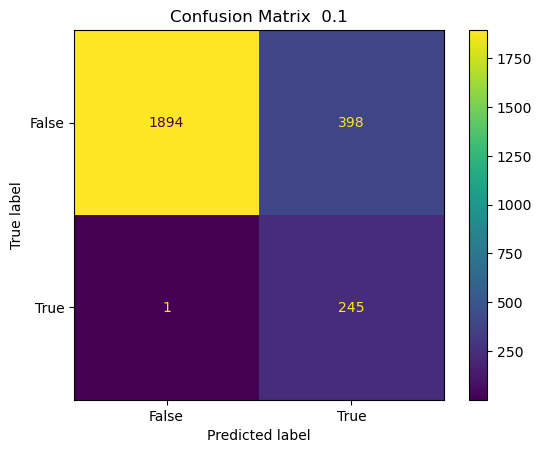

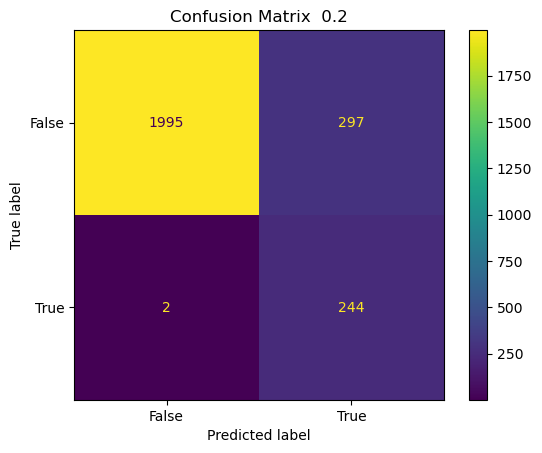

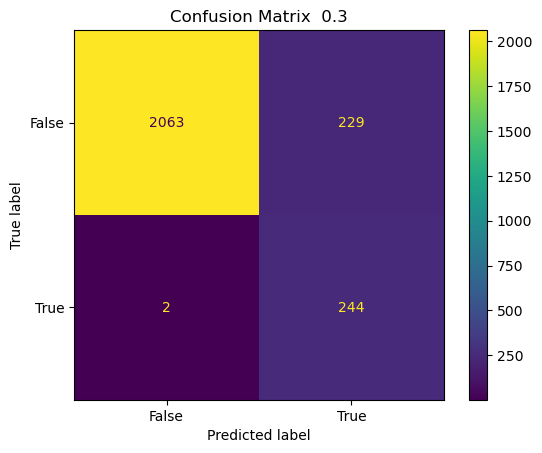

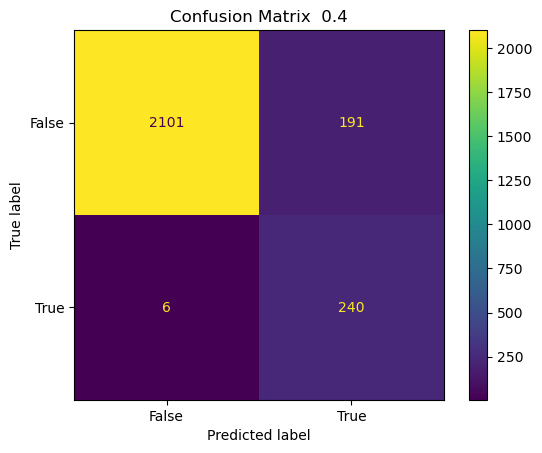

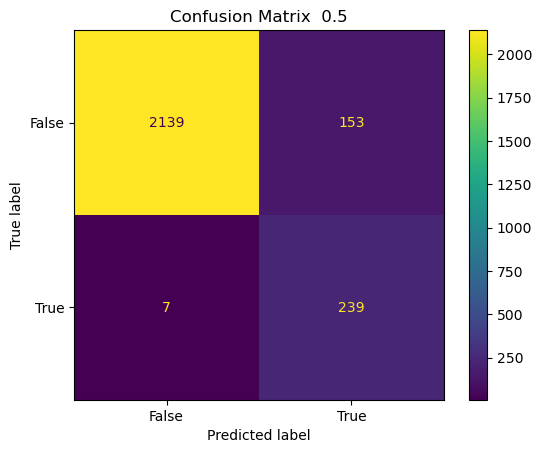

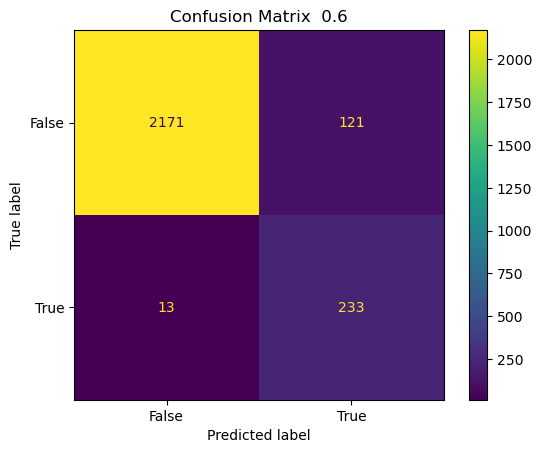

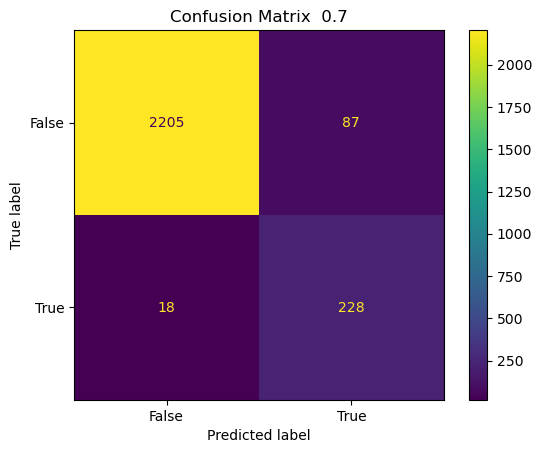

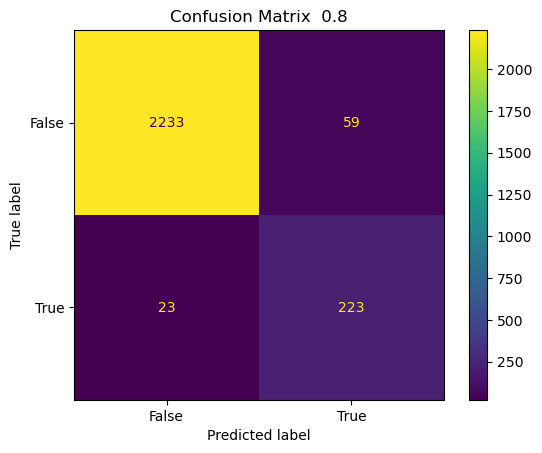

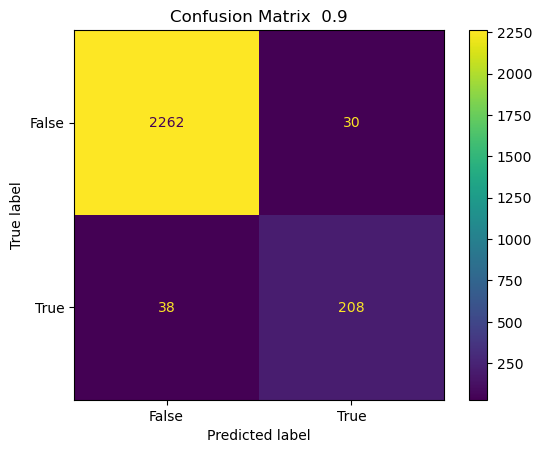

In [11]:
import matplotlib.pyplot as plt
# Calculate mean F1 scores over all folds
mean_f1_scores = np.mean(fold_f1_scores, axis=0)
mean_fhalf_scores = np.mean(fold_half_scores, axis=0)
mean_fdouble_scores = np.mean(fold_double_scores, axis=0)
mean_recall = np.mean(fold_recalls, axis=0)
mean_precision = np.mean(fold_precisions, axis=0)

for i in range(len(thresholds)):
     print("Fold", i*0.1+0.1, "  Precision: ", fold_precisions[i], "  Recall: ", fold_recalls[i])
     print("F1 Score: ", fold_f1_scores[i], "F-0.5 Score: ", fold_half_scores[i], "F-2 Score: ", fold_double_scores)
     print()

print("  Mean precision: ", mean_precision, "  Mean recall: ", mean_recall)
print(" Mean F1 Score: ", mean_f1_scores)
print(" Mean F-0.5 Score: ", mean_fhalf_scores)
print(" Mean F-0.5 Score: ", mean_fdouble_scores)


#Print confusion matrix
import matplotlib.pyplot as metrics
from sklearn.metrics import ConfusionMatrixDisplay

for i in range(len(fold_cm)):
    cm_display = ConfusionMatrixDisplay(confusion_matrix = fold_cm[i], display_labels = [False, True])
    cm_display.plot()
    title = i * 0.1+0.1
     
    plt.title(f'Confusion Matrix {title: .1f}')
    plt.show()
    
    
#pick 0.9 as threshold for now, but we might have to priotize recalls moving on

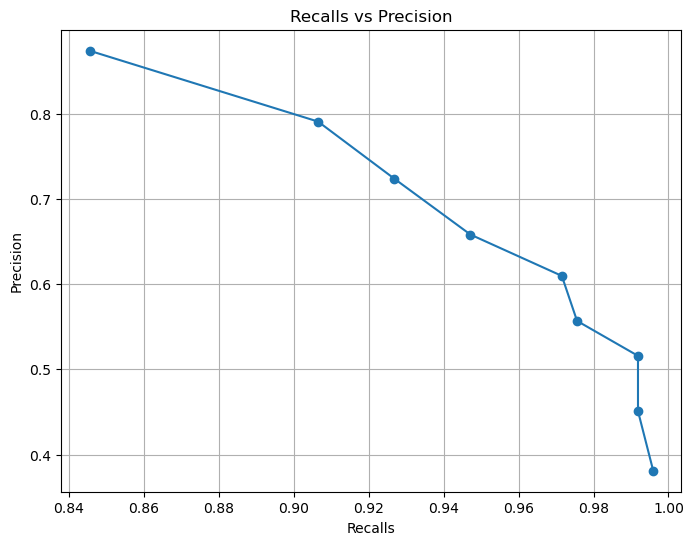

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(fold_recalls, fold_precisions, marker='o', linestyle='-')
plt.xlabel('Recalls')
plt.ylabel('Precision')
plt.title('Recalls vs Precision')
plt.grid(True)
plt.show()

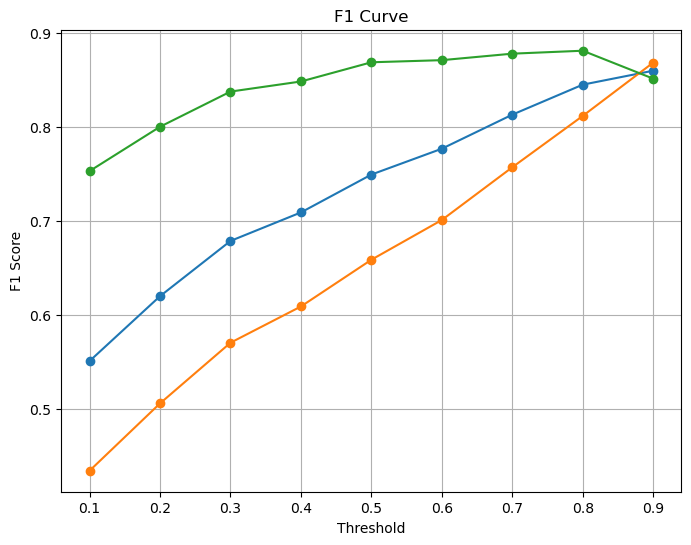

Mean F1 Score: 0.7335


In [15]:
#Plot the F1 curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fold_f1_scores, marker='o', linestyle='-')
plt.plot(thresholds, fold_half_scores, marker='o', linestyle='-')
plt.plot(thresholds, fold_double_scores, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Curve')
plt.grid(True)
plt.show()

# Display the mean F1 score
print(f"Mean F1 Score: {mean_f1_scores:.4f}")

#pick 0.7 threshold

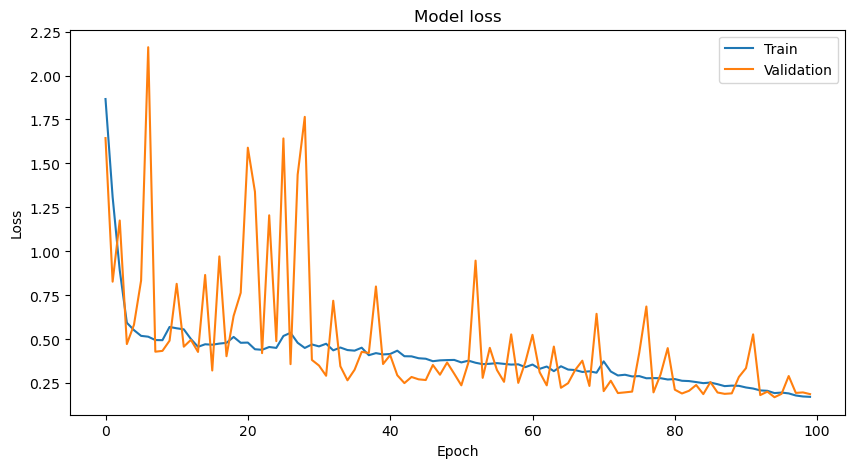

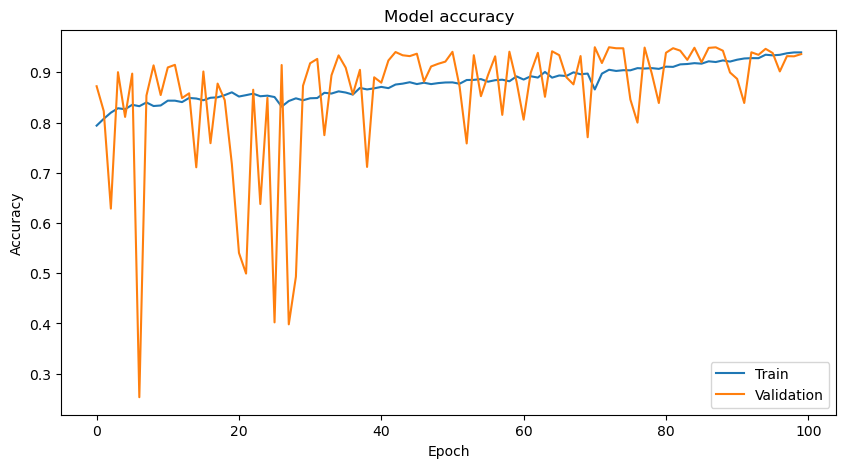

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

[0.01, 0.0099, 0.0098, 0.0097, 0.0096, 0.0095, 0.0094, 0.0093, 0.0092, 0.0091, 0.009000000000000001, 0.0089, 0.0088, 0.0087, 0.0086, 0.0085, 0.0084, 0.0083, 0.0082, 0.008100000000000001, 0.008, 0.0079, 0.0078000000000000005, 0.0077, 0.0076, 0.0075, 0.0074, 0.0073, 0.0072, 0.0070999999999999995, 0.006999999999999999, 0.0069, 0.0068, 0.006699999999999999, 0.006599999999999999, 0.006500000000000001, 0.0064, 0.0063, 0.0062, 0.0061, 0.006, 0.005900000000000001, 0.0058000000000000005, 0.005700000000000001, 0.005600000000000001, 0.0055000000000000005, 0.0054, 0.0053, 0.005200000000000001, 0.0051, 0.005, 0.0049, 0.0048, 0.0047, 0.0046, 0.0045, 0.004399999999999999, 0.004300000000000001, 0.004200000000000001, 0.0041, 0.004, 0.0039000000000000003, 0.0038, 0.0037, 0.0036, 0.0034999999999999996, 0.0034, 0.0032999999999999995, 0.0031999999999999997, 0.0031000000000000008, 0.0030000000000000005, 0.0029000000000000002, 0.0028000000000000004, 0.0027, 0.0026000000000000003, 0.0025, 0.0024, 0.0023, 0.00

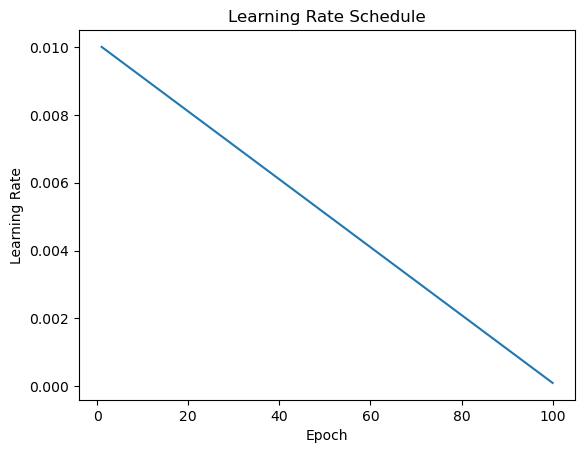

In [24]:
# Plot learning rate vs. epoch
print(learning_rates)
learning_rates.pop(0)
learning_rates.insert(0, 0.01)
plt.plot(range(1, 100 + 1), learning_rates)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

In [13]:
# Evaluate the model on the pseudo-test set
pseudo_test_loss, pseudo_test_accuracy = model.evaluate(np.expand_dims(X_val, -1), y_val)
print(f"Pseudo Test Loss: {pseudo_test_loss}")
print(f"Pseudo Test Accuracy: {pseudo_test_accuracy}")

80/80 [==============================] - 0s 5ms/step - loss: 0.2313 - accuracy: 0.9476
Pseudo Test Loss: 0.23131117224693298
Pseudo Test Accuracy: 0.947596549987793
